- https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition#EDA
- https://www.kaggle.com/code/ekami66/detailed-exploratory-data-analysis-with-python
- https://www.kaggle.com/code/niteshx2/top-50-beginners-stacking-lgb-xgb/notebook
- https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1/notebook#EDA
- https://www.kaggle.com/code/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda/report#header

In [170]:
import pandas as pd
import numpy as np
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

from functools import partial
from sklearn import ensemble, metrics, model_selection
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from timeit import default_timer as timer

pd.set_option('display.max_columns', None)
sns.set()

In [171]:
train=pd.read_csv('train.csv')

# EDA

In [172]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [173]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

`Alley` and `PoolQC` may be dropped. 

In [174]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Many right-skewed features, need to transform (log, box_cox, etc).

In [175]:
def miss_table(data):
    miss_table=data.isna().sum().to_frame(name='Count')
    miss_table['Percent']=miss_table['Count']/len(data)*100
    miss_table['Dtype']=data.dtypes[miss_table.index]
    miss_table['Count']=miss_table['Count'].replace({0: np.nan})
    miss_table=miss_table.dropna()
    print(f"There are {len(miss_table)}/{data.shape[1]} columns with missing values")
    print('Distribution by dtypes:')
    print(miss_table['Dtype'].value_counts())
    return miss_table.sort_values(by='Count', ascending=False)

mt=miss_table(train)
mt

There are 19/81 columns with missing values
Distribution by dtypes:
object     16
float64     3
Name: Dtype, dtype: int64


,Count,Percent,Dtype
PoolQC,1453.0,99.520548,object
MiscFeature,1406.0,96.301370,object
Alley,1369.0,93.767123,object
Fence,1179.0,80.753425,object
FireplaceQu,690.0,47.260274,object
LotFrontage,259.0,17.739726,float64
GarageType,81.0,5.547945,object
GarageYrBlt,81.0,5.547945,float64
GarageFinish,81.0,5.547945,object
GarageQual,81.0,5.547945,object


First 3-4 features may be dropped entirely, too much NaNs.

In [176]:
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [177]:
train.select_dtypes('object').nunique().sort_values(ascending=False)

Neighborhood     25
Exterior2nd      16
Exterior1st      15
SaleType          9
Condition1        9
Condition2        8
HouseStyle        8
RoofMatl          8
Functional        7
BsmtFinType2      6
Heating           6
RoofStyle         6
SaleCondition     6
BsmtFinType1      6
GarageType        6
Foundation        6
Electrical        5
FireplaceQu       5
HeatingQC         5
GarageQual        5
GarageCond        5
MSZoning          5
LotConfig         5
ExterCond         5
BldgType          5
BsmtExposure      4
MiscFeature       4
Fence             4
LotShape          4
LandContour       4
BsmtCond          4
KitchenQual       4
MasVnrType        4
ExterQual         4
BsmtQual          4
LandSlope         3
GarageFinish      3
PavedDrive        3
PoolQC            3
Utilities         2
CentralAir        2
Street            2
Alley             2
dtype: int64

`Neighborhood`, `Exterior2nd`, `Exterior1st` have highest cardinality out there. Not that much actually, OHE can be used.

mean=180921.196
std=79442.503
skewness=1.883
kurtosis=6.536


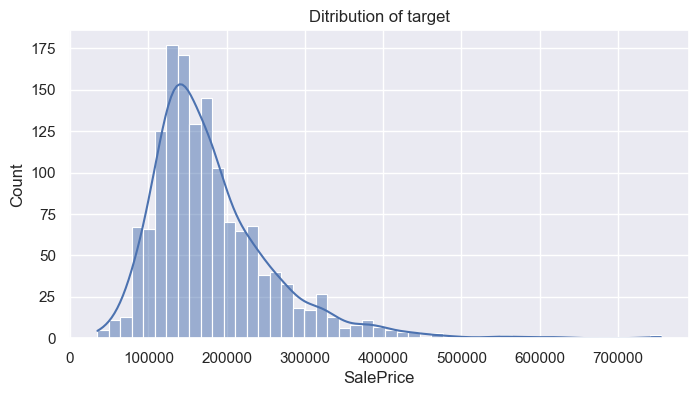

In [178]:
info=f'''mean={train["SalePrice"].mean():.3f}
std={train["SalePrice"].std():.3f}
skewness={train["SalePrice"].skew():.3f}
kurtosis={train["SalePrice"].kurt():.3f}'''
print(info)

fig, axes=plt.subplots(figsize=(8,4))
sns.histplot(train['SalePrice'], kde=True, ax=axes);
plt.title('Ditribution of target')
plt.show()

Right-skewed (some very high-price houses), high kurtosis (fat tails, some outliers). Need to transform, may help with performance.

In [179]:
def num_plot(data, pl_type='scatter'):
    nums=train.select_dtypes(['number']).columns
    fig, axs = plt.subplots(int(np.ceil(len(list(data[nums]))/3)), 3, figsize=(12, 65))
    plt.subplots_adjust(right=1.5)
    plt.subplots_adjust(top=1.5)
    for i, feature in enumerate(list(data[nums])):
        if(feature=='SalePrice'):
            break
        if pl_type=='scatter':
            sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Reds', data=data, ax=axs[i//3, i%3])
        else:
            sns.histplot(x=feature, data=data, kde=True, ax=axs[i//3, i%3])


        plt.xlabel('{}'.format(feature), size=15, labelpad=1.5)
        plt.ylabel('SalePrice', size=15, labelpad=12.5)

        for j in range(2):
            plt.tick_params(axis='x', labelsize=12)
            plt.tick_params(axis='y', labelsize=12)

    plt.show()
    
# num_plot(train)

Eye-balled some outliers there, will remove them later.

In [180]:
# num_plot(train, 'hist')

In [181]:
def cat_plot(data, pl_type='box'):
    cats=train.select_dtypes(['object', 'category']).columns
    fig, axs = plt.subplots(int(np.ceil(len(list(data[cats]))/3)), 3, figsize=(12, 30))
    plt.subplots_adjust(right=1.5)
    plt.subplots_adjust(top=2.5)
    for i, feature in enumerate(list(data[cats])):
        if(feature=='SalePrice'):
            break
        if pl_type=='box':
            sns.boxplot(x=feature, y="SalePrice", data=data, ax=axs[i//3, i%3])
            axs[i//3, i%3].set_xticks(range(len(data[feature].unique())), data[feature].unique(), rotation=45, ha='right')
        else:
            val_c=data[feature].value_counts().to_frame()
            sns.barplot(x=feature, y=val_c.index, data=val_c, ax=axs[i//3, i%3])


        plt.xlabel('{}'.format(feature), size=15, labelpad=1.5)
        plt.ylabel('SalePrice', size=15, labelpad=12.5)

        for j in range(2):
            plt.tick_params(axis='x', labelsize=12)
            plt.tick_params(axis='y', labelsize=12)

    plt.show()
    
# cat_plot(train)

In [182]:
# cat_plot(train, 'bar')

C:\Users\akim2\AppData\Local\Temp\ipykernel_7456\404622875.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=train.corr()


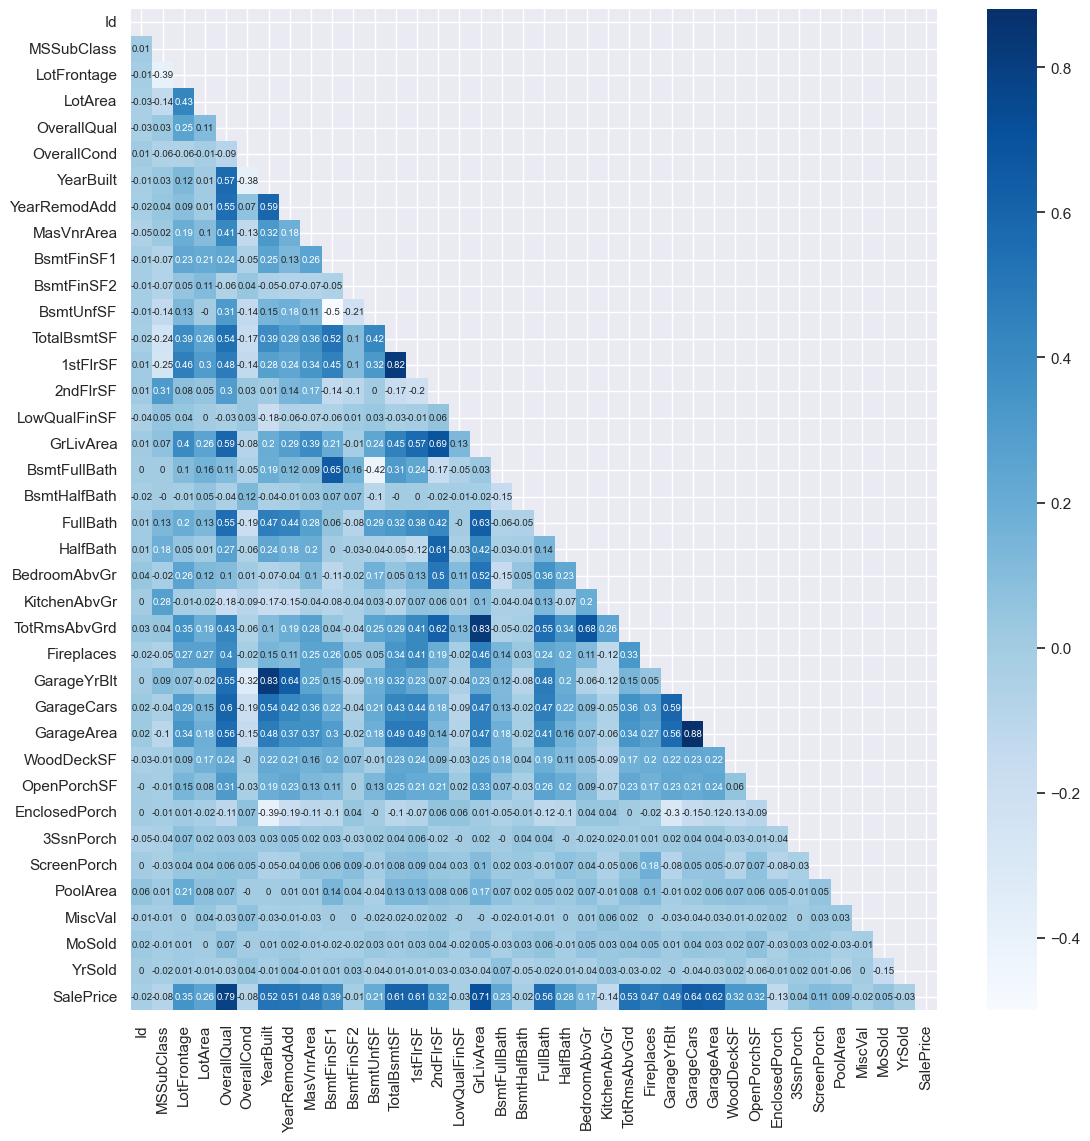

In [183]:
corr=train.corr()
mask=np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)]=True

plt.subplots(figsize=(13,13))
sns.heatmap(round(corr,2),
    cmap="Blues", mask=mask, annot=True, annot_kws={"size": 7});

There are some highly correlated variables (e.g., `GarageCars` and `GarageArea`). Should keep one of them.

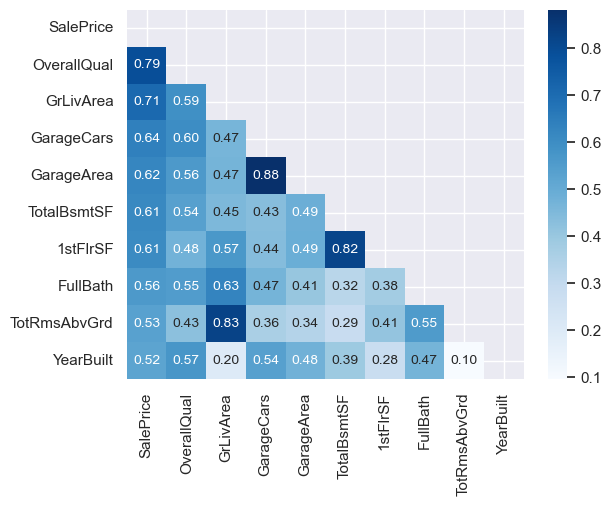

In [184]:
k=10
top_corrs=corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm=np.corrcoef(train[top_corrs].values.T)

mask=np.zeros_like(cm, dtype=bool)
mask[np.triu_indices_from(mask)]=True

# sns.set(font_scale=1.25)
hm=sns.heatmap(cm, cbar=True, annot=True, fmt='.2f', cmap="Blues", 
                annot_kws={'size': 10}, yticklabels=top_corrs.values, xticklabels=top_corrs.values,
                mask=mask)
plt.show()

# Feature Engineering

In [185]:
def drop_outliers(frame):
    to_drop=[]
    data=frame.copy()
    print(f'Shape before: {data.shape}')
    to_drop.append(data[data['SalePrice']>700000].index.values)
    to_drop.append(data[data['LotFrontage']>300].index.values)
    to_drop.append(data[data['LotArea']>150000].index.values)
    to_drop.append(data[(data['YearBuilt']<1900) & (data['SalePrice']>200000)].index.values)
    to_drop.append(data[data['MasVnrArea']>1400].index.values)
    to_drop.append(data[(data['BsmtFinSF2']>400) & (data['BsmtFinSF2']<600) & (data['SalePrice']>500000)].index.values)
    to_drop.append(data[data['1stFlrSF']>4000].index.values)
    to_drop.append(data[data['GrLivArea']>4000].index.values)
    to_drop.append(data[(data['GarageArea']>1200) & (data['SalePrice']<300000)].index.values)
    to_drop.append(data[data['OpenPorchSF']>400].index.values)
    to_drop.append(data[data['MiscVal']>8000].index.values)
    to_drop=set(np.concatenate(to_drop).ravel())
    print(sorted(to_drop))
    data=data.drop(to_drop)
    print(f'{len(to_drop)} samples are dropped')
    print(f'Shape after: {data.shape}')
    return data

In [186]:
train=drop_outliers(train)

Shape before: (1460, 81)
[185, 249, 297, 304, 313, 335, 346, 440, 495, 523, 581, 583, 691, 747, 854, 934, 1061, 1182, 1190, 1230, 1298, 1328]
22 samples are dropped
Shape after: (1438, 81)


mean=12.018
std=0.391
skewness=0.092
kurtosis=0.586


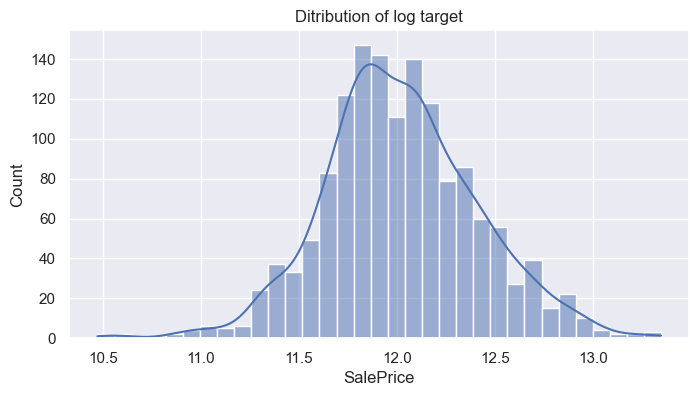

In [187]:
train["SalePrice"]=np.log1p(train["SalePrice"])

info=f'''mean={train["SalePrice"].mean():.3f}
std={train["SalePrice"].std():.3f}
skewness={train["SalePrice"].skew():.3f}
kurtosis={train["SalePrice"].kurt():.3f}'''
print(info)

fig, axes=plt.subplots(figsize=(8,4))
sns.histplot(train['SalePrice'], kde=True, ax=axes);
plt.title('Ditribution of log target');

# Modelling

In [209]:
import lightgbm as lgb

def custom_lgbm_cv(features, target, col_tran, k=5):
    metric_df=pd.DataFrame(columns=['Train rmse', 'Test rmse'])
    feat_importances=[]
    kfold=KFold(k, shuffle=True)
    for f, (tr, te) in enumerate(kfold.split(features, y=target)):
        X_train, y_train=features.iloc[tr, :], target.iloc[tr]
        X_test, y_test=features.iloc[te, :], target.iloc[te]

        X_train_tr=col_tran.fit_transform(X_train)
        X_test_tr=col_tran.transform(X_test)

        params=dict(objective='regression', 
                    metrics='rmse',
                    num_leaves=6,
                    learning_rate=0.01, 
                    n_estimators=7000,
                    max_bin=200, 
                    bagging_fraction=0.8,
                    bagging_freq=4, 
                    bagging_seed=8,
                    feature_fraction=0.2,
                    feature_fraction_seed=8,
                    min_sum_hessian_in_leaf = 11,
                    verbose=-1,
                    random_state=42)

        dtrain=lgb.Dataset(X_train_tr, label=y_train)
        dval=lgb.Dataset(X_test_tr, label=y_test)

        model=lgb.train(
                params=params,
                train_set=dtrain,
                valid_sets=[dtrain, dval],
                valid_names=['train', 'test'],
                callbacks=[lgb.early_stopping(10, verbose=-1), lgb.log_evaluation(-1)],
        # categorical_feature=a
        )
        
        test_score, train_score=model.best_score['test']['rmse'], model.best_score['train']['rmse']
        metric_df.loc[f]=[train_score, test_score]
        
        feat_importances.append(model.feature_importance(importance_type='gain'))
        
    # feat_importances=np.array(feat_importances).mean(axis=0)
    # feat_importances_df=pd.DataFrame({'feature': col_tran.get_feature_names_out(),
    #                                 'importance': feat_importances})

    metric_df.loc['Avg']=[metric_df['Train rmse'].mean(), metric_df['Test rmse'].mean()]
    return metric_df,2

In [210]:
X, y=train.drop(['Id', 'SalePrice'], axis=1), train['SalePrice']
cat_cols, num_cols=X.select_dtypes(include=['category', 'object']).columns, X.select_dtypes('number').columns

In [211]:
a=[]

for i in  train.columns:
    if i in cat_cols:
        a.append(1)
    else:
        a.append(0)

In [212]:
def quick_cv(df):
    X, y=train.drop(['Id', 'SalePrice'], axis=1), train['SalePrice']

    cat_cols, num_cols=X.select_dtypes(include=['category', 'object']).columns, X.select_dtypes('number').columns

    ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
    ordin=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10)
    rob_sc=RobustScaler()
    col_tr=ColumnTransformer([
        ('cat', ohe, cat_cols),
        ('num', 'passthrough', num_cols)
    ])


    res, imps=custom_lgbm_cv(X, y, col_tr, 10)
    return res, imps

res, imps=quick_cv(train)

c:\Users\akim2\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1159]	train's rmse: 0.0854002	test's rmse: 0.15101
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1071]	train's rmse: 0.0908727	test's rmse: 0.109844
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[937]	train's rmse: 0.0941005	test's rmse: 0.111985
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1132]	train's rmse: 0.0910785	test's rmse: 0.0951745
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1006]	train's rmse: 0.0927942	test's rmse: 0.0956209
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1107]	train's rmse: 0.089653	test's rmse: 0.104439
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1387]	train's rmse: 0.0863857	test's rmse: 0.104404
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1164]	train's rmse: 0.0879183	test's rmse: 0.119358
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[828]	train's rmse: 0.0912155	test's rmse: 0.143438
Training until validation scores don't improve for 10 rounds


c:\Users\akim2\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\akim2\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1026]	train's rmse: 0.0918813	test's rmse: 0.0917997


In [213]:
res

,Train rmse,Test rmse
0,0.085400,0.151010
1,0.090873,0.109844
2,0.094101,0.111985
3,0.091078,0.095175
4,0.092794,0.095621
5,0.089653,0.104439
6,0.086386,0.104404
7,0.087918,0.119358
8,0.091215,0.143438
9,0.091881,0.091800
